In [1]:
import os, sys, json, argparse
import pandas as p
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
from string import punctuation

In [2]:


with open('/Users/kenmckee/Desktop/GS/S18/tm/Project/PJ/CKOne.json') as fd:
    script = json.load(fd)
    
    #print(script)

In [3]:
BLOCK_TYPES=['character', 'speech', 'stage direction', 'location']
CHARACTER=0
SPEECH=1
DIRECTIONS=2
LOCATION=3

In [4]:
def extract_characters(script):
    '''
    Extracts the (unique) characters list from the script
    '''
    characters=[]
    for block in script['movie_script']:
        if(block['type'] == BLOCK_TYPES[SPEECH]):
            character = block['character']
            if not character in characters:
                characters.append(character)

    return characters

def extract_locations(script):
    '''
    Extracts the (unique) locations list from the script
    '''
    locations=[]
    for block in script['movie_script']:
        if(block['type'] == BLOCK_TYPES[LOCATION]):
            location = block['text']
            if not location in locations:
                locations.append(location)

    return locations

def extract_directions(script):
    '''
    Extracts the stage directions list from the script
    '''
    directions=[]
    for block in script['movie_script']:
        if(block['type'] == BLOCK_TYPES[DIRECTIONS]):
            directions.append(block['text'])

    return directions

def extract_speech_given_character(script, character, strict_match=False):
    '''
    Extracts the given character's utterances from the script

    If strict_match is True, we will only extract utterances that perfectly match (==) the parameter;
    otherwise, we will extract utterances whose character partly matches (in) the parameter.
    In both cases, the match is case-insensitive.

    Also asks the user wether one wants to keep the character's name before each utterance.
    '''

    speeches=[]
    for block in script['movie_script']:
        if( block['type'] == BLOCK_TYPES[SPEECH] and
            (strict_match and (character.lower() == block['character'].lower()) or
             not strict_match and (character.lower() in block['character'].lower())) ):
            if( keep_character_name ):
                speeches.append(block['character'])
            speeches.append(block['text'])

    return speeches

def extract_all_characters_speech(script):
    '''
    Extracts all speeches from the script
    '''
    return extract_speech_given_character(script, '')

def extract_speech_asking_user(script):
    '''
    Extracts utterances by asking the user which character one wants to get

    Also asks wether the user wants a perfect (==) or partial (in) match.
    '''
    character = input_string('Please provide the name of the character: ')

    strict_match = False
    answer = input('Do you want utterances of this exact character (or any character that matches \'{}\')? (y/N) '.format(character))
    if( answer == 'y' or answer =='Y' ):
        strict_match = True

    return extract_speech_given_character(script, character, strict_match)

def extract_speech_using_characters_list(script):
    '''
    Extracts utterances by providing the user with the characters list

    Also asks wether the user wants a perfect (==) or partial (in) match.
    '''
    characters = sorted(extract_characters(script))
    character = characters[input_from_list('Please choose a character:', characters)]

    strict_match = False
    answer = input('Do you want utterances of this exact character (or any character that matches \'{}\')? (y/N) '.format(character))
    if( answer == 'y' or answer =='Y' ):
        strict_match = True

    return extract_speech_given_character(script, character, strict_match)

def extract_speech(script):
    '''
    Asks the user which speeches one wants to extract, and calls the appropriate function
    '''
    speech=[]

    choices = ['all characters',
               'give the character\'s name',
               'choose from the characters list']

    action = input_from_list("Which character speeches do you want to extract?", choices)

    if( action == 0 ):
        return extract_all_characters_speech(script)
    elif( action == 1 ):
        return extract_speech_asking_user(script)
    elif( action == 2 ):
        return extract_speech_using_characters_list(script)




In [5]:
result_character = extract_characters(script)
result_direction = extract_directions(script)
result_location = extract_locations(script)



#print(result_location)
#print(result_location)

In [6]:
keep_character_name = True
strict_match = False

text=[]
characters=[]
for character in result_character:
    for block in script['movie_script']:
        if( block['type'] == BLOCK_TYPES[SPEECH] and
            (strict_match and (character.lower() == block['character'].lower()) or
             not strict_match and (character.lower() in block['character'].lower())) ):
            if( keep_character_name ):
                characters.append(block['character'])
                text.append(block['text'])








Pivoted to numbers and combined some pesky records together. 
cleaned up some unmanageable formats and built an input csv for posterity

In [7]:
pre=p.read_csv("/Users/kenmckee/Desktop/pri.csv", delimiter=',') 

#print(pre)
pre = pre.replace('\n',' ', regex=True)
pre = pre.replace('\r',' ', regex=True)
pre = pre.replace('\.','', regex=True)

chars = chars = ['KANE','BERNSTEIN','LELAND','MRS KANE','KANE SR','RAYMOND','SUSAN','THATCHER','THOMPSON','EMILY','RAWLSTON','KELLY']

ccorpus = pre.loc[pre['char'].isin(chars)]
ccorpus = ccorpus.groupby('char')['text'].apply(' '.join).reset_index()
#ccorpus = ccorpus.apply(lambda x: x.str.strip() if x.dtype == "object" else x)




char=ccorpus['char'].values 
text=ccorpus['text'].values
#y=pre['char'].values 
#X=pre['text'].values

#print(ccorpus.groups)

#print(pre)

In [8]:
list = 'say','what','are','you','mr','did','say'
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['oh','say','yes','what','are','you','mr','did','say','right','got','going','let','looking','want','ca',"'d",'new'])
stopwords.extend(['kane','bernstein','leland','thompson','emily','charles','susan','brad','rogers','charlie'])
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [9]:
import re
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token not in stopwords:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token not in stopwords:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
    return filtered_tokens




In [10]:
#this is to analyze the characters
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

       


for i in text:
    
    
   # allwords_stemmed = tokenize_and_stem(i) #for each item in 'courseDesc', tokenize/stem
   # totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
    

In [11]:
vocab_frame = p.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_tokenized)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

print(vocab_frame.head())
print
print
print
print



there are 7074 items in vocab_frame
             words
mr              mr
thatcher  thatcher
wire          wire
cuba          cuba
mr              mr


<function print>

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=30, max_features=1500,
                                 min_df=5, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,5))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
#print(dist)

CPU times: user 159 ms, sys: 4.64 ms, total: 164 ms
Wall time: 163 ms
(11, 123)


<function print>

In [13]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()



In [14]:
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

#print(clusters)

CPU times: user 30.8 ms, sys: 267 µs, total: 31.1 ms
Wall time: 31.2 ms


In [15]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster.pkl')

#km = joblib.load('doc_cluster.pkl')
#clusters = km.labels_.tolist()

#joblib.dump(tkm,  'doc_cluster.pkl')

#km = joblib.load('doc_cluster.pkl')
#clusters = tkm.labels_.tolist()


#print(clusters)

In [16]:
films = { 'title': char,'text': text, 'cluster': clusters}
frame = p.DataFrame(films, index = [clusters] , columns = ['title', 'text'])
framex = p.DataFrame(films,  columns = ['title', 'text','cluster'])


#frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

#print(frame)



grouped = frame.groupby(frame['title']) #groupby cluster for aggregation purposes

#grouped.mean() #average rank (1 to 100) per cluster

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b"n't", b"'s", b'mr', b"'m", b'know', b"'re", b'think', b"'ll", b"'ve", b'going',

Cluster 0 titles: BERNSTEIN, EMILY, KANE, LELAND, SUSAN, THATCHER, THOMPSON,

Cluster 1 words: b'mr', b'thatcher', b"'s", b'mr', b"n't", b'going', b"'re", b"'re", b'want', b"'ve",

Cluster 1 titles: KANE SR, MRS KANE,

Cluster 2 words: b'yes', b'mr', b"n't", b'knew', b'mrs', b'said', b'foster', b'years', b"'s", b'say',

Cluster 2 titles: RAYMOND,

Cluster 3 words: b"'s", b'man', b'thing', b'people', b'good', b'rosebud', b'minute', b'probably', b'mean', b'knew',

Cluster 3 titles: RAWLSTON,





/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [17]:
framex['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)


0    7
1    2
3    1
2    1
Name: cluster, dtype: int64

In [18]:
fclust = ['1']
ccps = framex.loc[framex['cluster'].isin(fclust)]

print(ccps)

      title                                               text  cluster
3   KANE SR  You people seem to forget that I'm the boy's f...        1
5  MRS KANE  calling out Be careful Charles! Calling out th...        1


In [19]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'yes, leland, going', 
                 1: 'got, look, notice', 
                 2: 'susan, want, way',
                 3: 'bernstein, new, right', 
                 4: 'let, chronicle, little'}

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


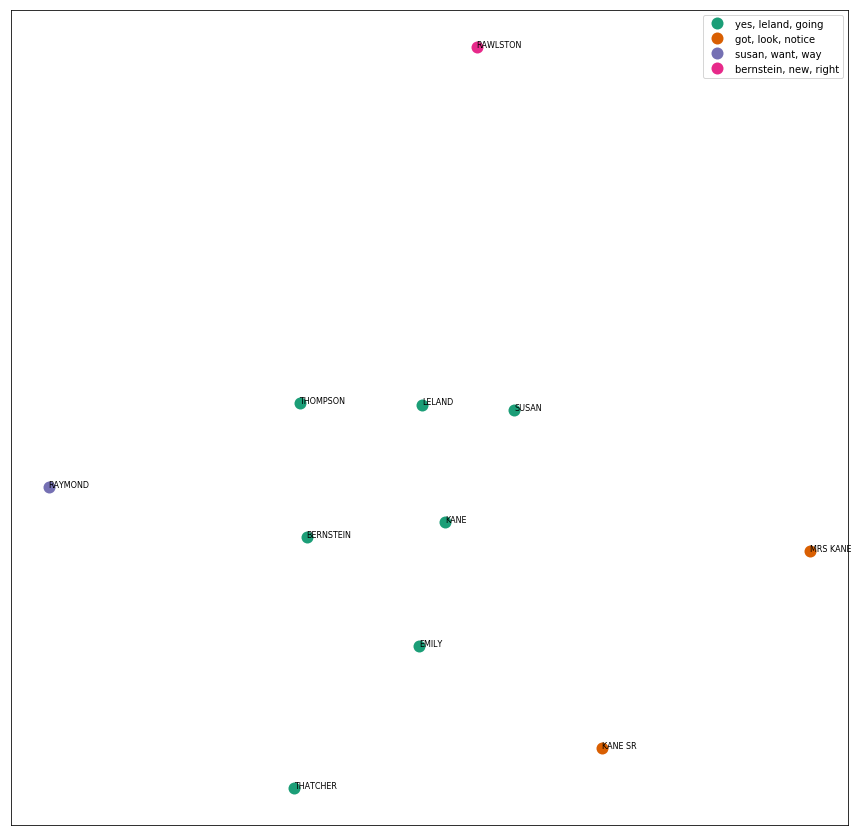

In [20]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = p.DataFrame(dict(x=xs, y=ys, label=clusters, title=char)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(15,15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


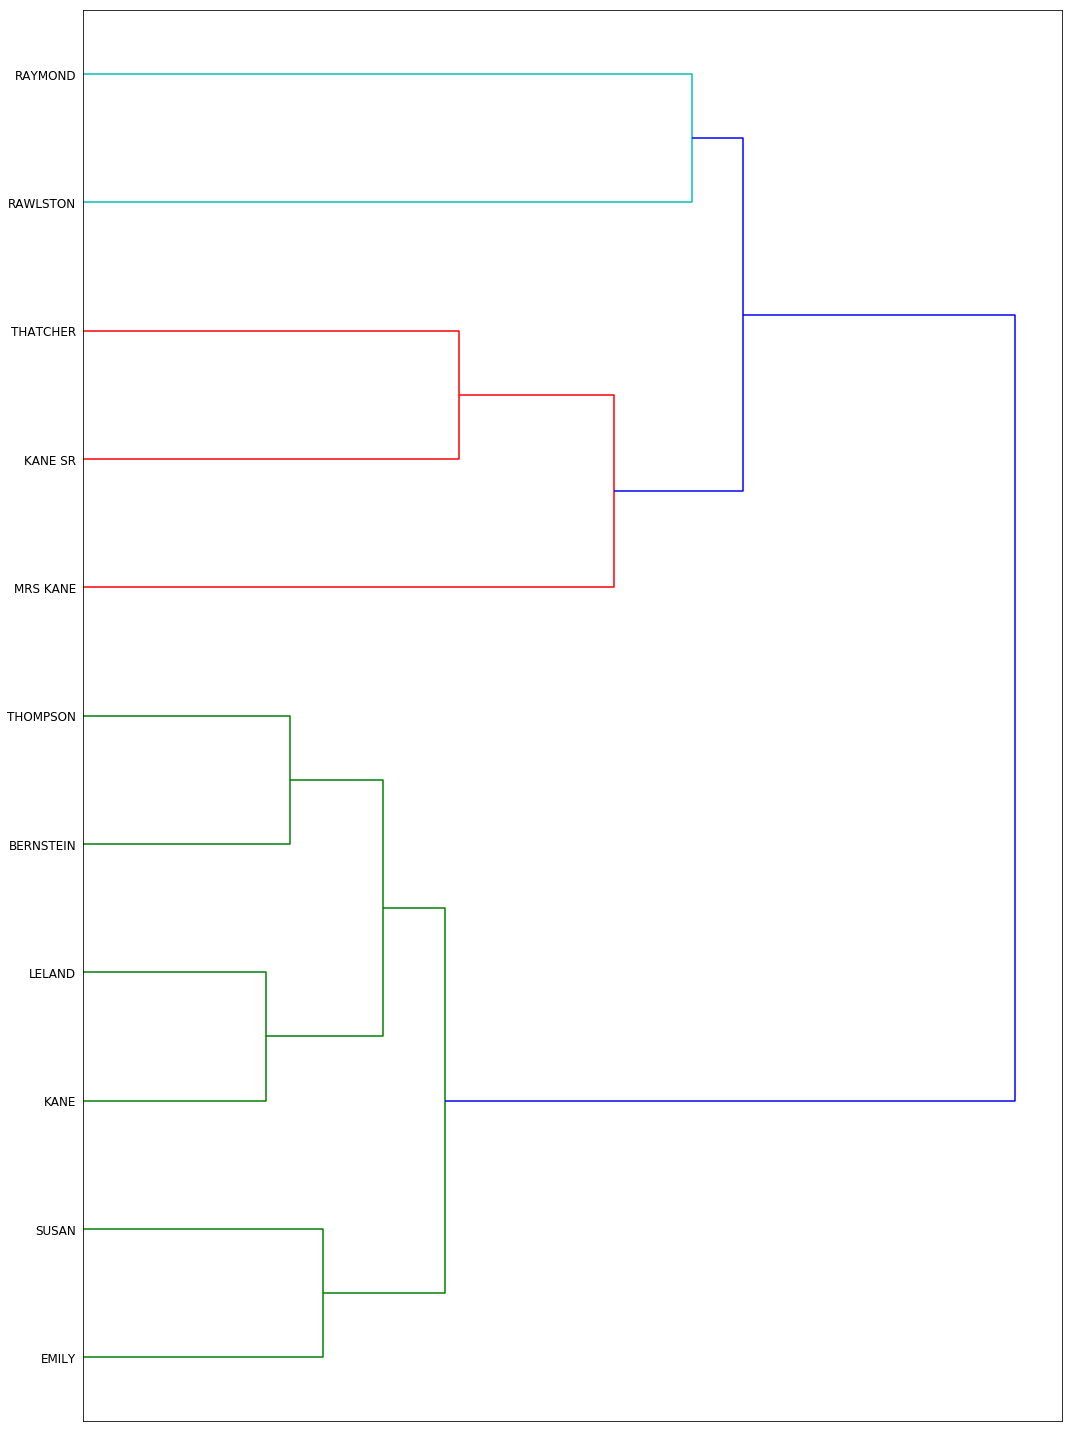

In [21]:
plt.close()

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = p.DataFrame(dict(x=xs, y=ys, label=clusters, title=char)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=char);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters



In [22]:
#fd = open(out_filename, 'w')
#fd.write(result_string)


In [23]:
from gensim import corpora, models, similarities 


#tokenize
%time tokenized_text = [tokenize_only(text) for text in ccorpus]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in text]

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=50)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

%time 
lda = models.LdaModel(corpus, num_topics=8, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)




CPU times: user 568 µs, sys: 1 µs, total: 569 µs
Wall time: 575 µs
CPU times: user 110 ms, sys: 536 µs, total: 110 ms
Wall time: 111 ms
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [24]:
lda.show_topics()

[(0,
  '0.270*" " + 0.202*"e" + 0.095*"r" + 0.086*"n" + 0.074*"h" + 0.050*"l" + 0.022*"u" + 0.022*"p" + 0.022*"g" + 0.021*"f"'),
 (1,
  '0.324*" " + 0.139*"e" + 0.093*"n" + 0.066*"u" + 0.061*"h" + 0.043*"r" + 0.038*"w" + 0.035*"l" + 0.028*"g" + 0.019*"\'"'),
 (2,
  '0.018*"7" + 0.018*"5" + 0.018*"J" + 0.018*"4" + 0.018*"&" + 0.018*"X" + 0.018*"8" + 0.018*"e" + 0.018*" " + 0.018*"f"'),
 (3,
  '0.313*" " + 0.126*"e" + 0.092*"n" + 0.072*"r" + 0.048*"h" + 0.045*"l" + 0.035*"g" + 0.033*"u" + 0.031*"p" + 0.027*"c"'),
 (4,
  '0.325*" " + 0.110*"e" + 0.088*"h" + 0.071*"r" + 0.062*"l" + 0.060*"n" + 0.037*"u" + 0.034*"g" + 0.027*"\'" + 0.025*"c"'),
 (5,
  '0.018*"7" + 0.018*"5" + 0.018*"J" + 0.018*"&" + 0.018*"4" + 0.018*"X" + 0.018*"8" + 0.018*"e" + 0.018*"g" + 0.018*"f"'),
 (6,
  '0.018*"7" + 0.018*"5" + 0.018*"J" + 0.018*"&" + 0.018*"4" + 0.018*"X" + 0.018*"8" + 0.018*"e" + 0.018*"g" + 0.018*"f"'),
 (7,
  '0.348*" " + 0.118*"e" + 0.076*"n" + 0.072*"h" + 0.057*"l" + 0.049*"r" + 0.039*"u" + 0.0

In [25]:
topics_matrix = lda.show_topics(formatted=False, num_words=5)
print(topics_matrix)
#topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

[(0, [(' ', 0.2702107), ('e', 0.20193414), ('r', 0.09525116), ('n', 0.08635104), ('h', 0.074394345)]), (1, [(' ', 0.324186), ('e', 0.13856424), ('n', 0.09304554), ('u', 0.066392705), ('h', 0.061425745)]), (2, [('7', 0.017857168), ('5', 0.017857168), ('J', 0.017857151), ('&', 0.017857147), ('4', 0.017857147)]), (3, [(' ', 0.31273317), ('e', 0.12579796), ('n', 0.09207802), ('r', 0.07204572), ('h', 0.0477808)]), (4, [(' ', 0.32465452), ('e', 0.1103825), ('h', 0.088439204), ('r', 0.071188144), ('l', 0.062196836)]), (5, [('7', 0.017857168), ('5', 0.017857168), ('J', 0.017857151), ('&', 0.017857147), ('4', 0.017857147)]), (6, [('7', 0.017857168), ('5', 0.017857168), ('J', 0.017857151), ('&', 0.017857147), ('4', 0.017857147)]), (7, [(' ', 0.34772018), ('e', 0.11812779), ('n', 0.07636428), ('h', 0.071671866), ('l', 0.057410747)])]


TypeError: list indices must be integers or slices, not tuple